# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [252]:
import math

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [253]:
import warnings
warnings.filterwarnings('ignore')

# from pyfeatures import features,calc_features
%load_ext autoreload
%autoreload 2
from pyfeatures import features,calc_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [254]:
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

# start_datetime = datetime.datetime.strptime("2022-5-7 00:00:00", "%Y-%m-%d %H:%M:%S")
# end_datetime = datetime.datetime.strptime("2018-01-07 00:00:00", "%Y-%m-%d %H:%M:%S")
# target_coin = "FX_BTC_JPY"


# ohlc_list=[]
# while start_datetime > end_datetime:
#     unixtime = start_datetime.timestamp() * 1000
#     response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
#     ohlc_list.extend(response)
#     start_datetime -= timedelta(minutes=720)
#     time.sleep(1)


# df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
# df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
# df_1m.set_index("timestamp",inplace=True)
# df_1m.sort_index(inplace=True)
# display(df_1m)

# df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

1分足のOHLCVを15分足に変換します。

In [255]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835
...,...,...,...,...,...
2022-05-06 11:00:00+00:00,4737209.0,4763389.0,4702323.0,4721553.0,210.899548
2022-05-06 11:15:00+00:00,4721181.0,4728110.0,4687535.0,4709700.0,162.779580
2022-05-06 11:30:00+00:00,4709364.0,4747896.0,4697567.0,4722130.0,167.315703


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [256]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980,0.0
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245,0.0
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456,0.0
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831,0.0
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835,0.0
...,...,...,...,...,...,...
2022-05-06 11:00:00+00:00,4737209.0,4763389.0,4702323.0,4721553.0,210.899548,0.0
2022-05-06 11:15:00+00:00,4721181.0,4728110.0,4687535.0,4709700.0,162.779580,0.0
2022-05-06 11:30:00+00:00,4709364.0,4747896.0,4697567.0,4722130.0,167.315703,0.0


## 特徴量エンジニアリング

## 学習に使う特徴量の定義

## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


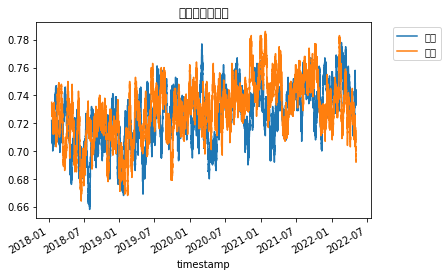

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


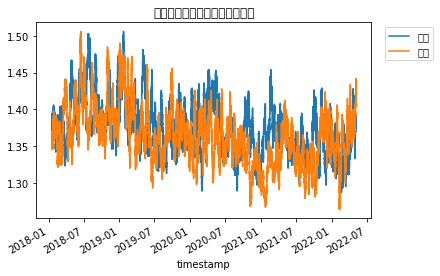

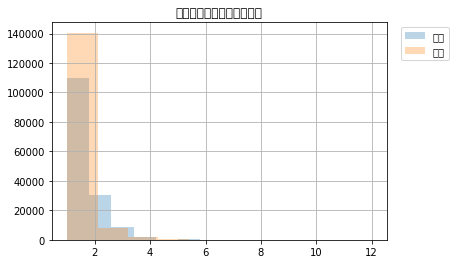

毎時刻、この執行方法でトレードした場合の累積リターン


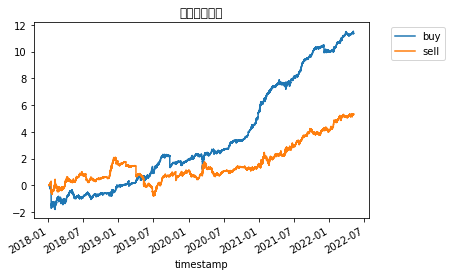

109742
110391


In [257]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
# limit_price_dist = df['ATR'] * 0.5
# limit_price_dist = df['ATR'] * 0.1
limit_price_dist = df['ATR'] * 0.2
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()
print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy')
df['y_sell'].cumsum().plot(label='sell')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# df = df[df['y_buy']!= 0]
# print('毎時刻、この執行方法でトレードした場合の累積リターン')
# df['y_buy'].cumsum().plot(label='買い')
# df['y_sell'].cumsum().plot(label='売り')
# plt.title('累積リターン')
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.show()
df

print(len(df[df['y_buy']!=0]))
print(len(df[df['y_sell']!=0]))

df.to_pickle('df_bf_fx_y.pkl')

In [258]:
# from pycaret.regression import *
# import copy
# df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df.dropna()
# features_ybuy = copy.deepcopy(features)
# features_ybuy.append('y_buy')
# exp1 = setup(df[features_ybuy], target = 'y_buy')
# model_pycaret = create_model('lightgbm')
# tuned_model = tune_model(model_pycaret, n_iter = 50, optimize = 'mae')
# tuned_model.get_params

## モデルの学習とOOS予測値計算

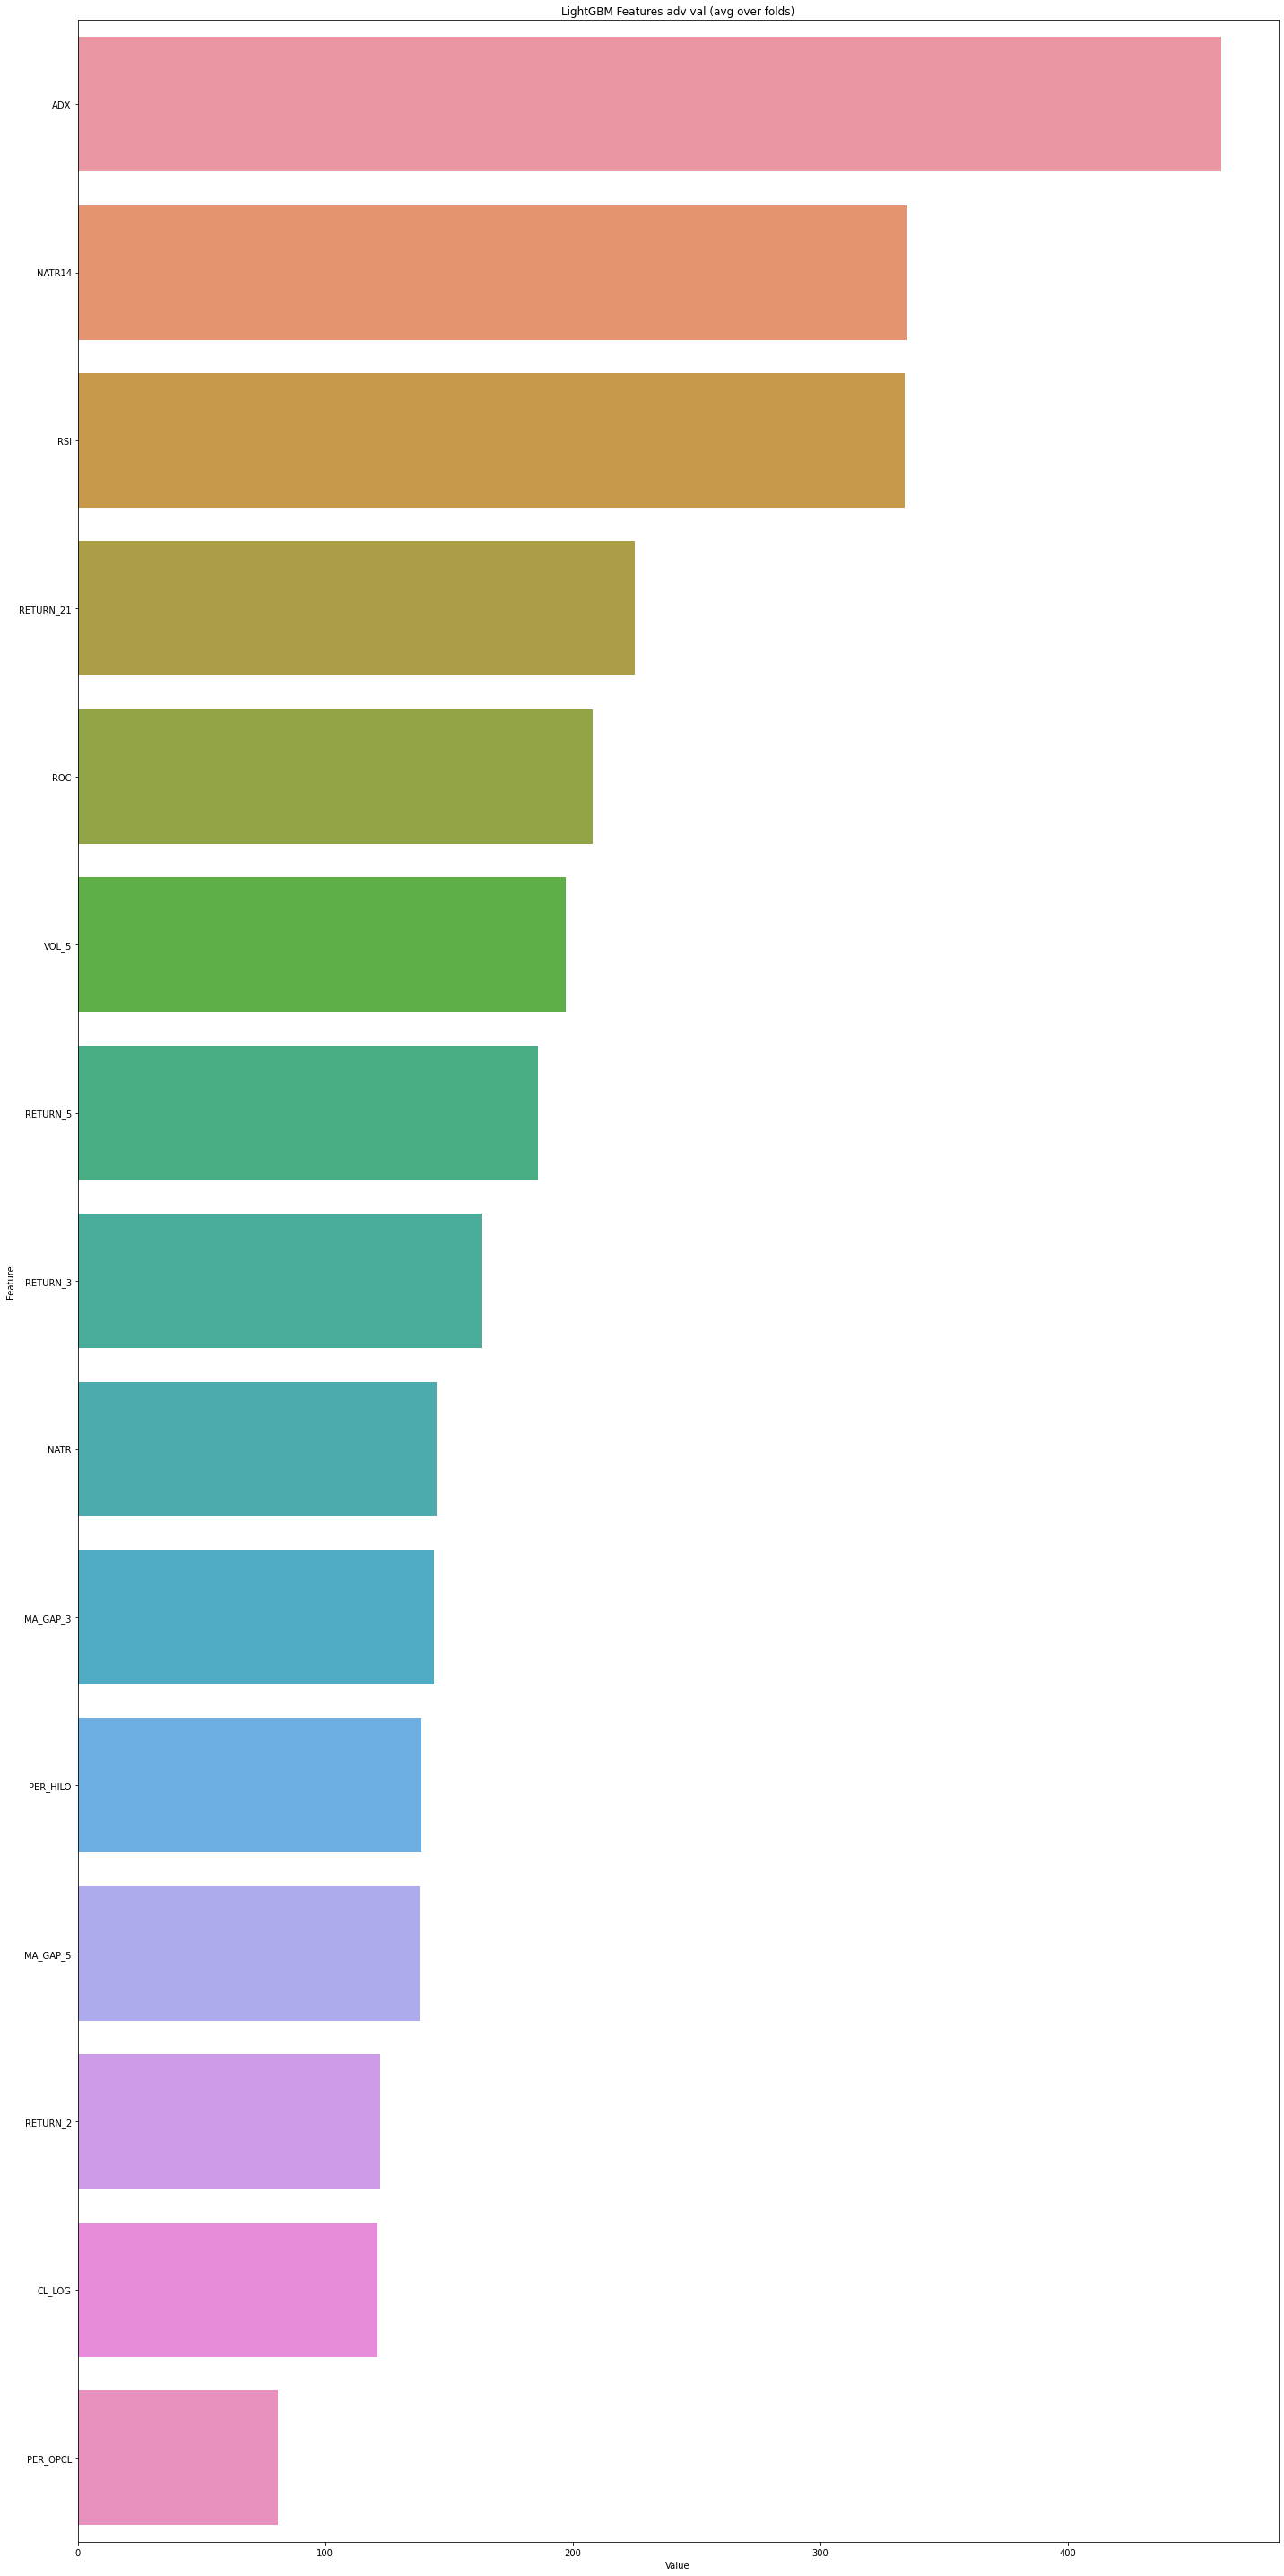

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.12646036 0.12719519]
score mean, std 0.12682777431486897 0.00036741885508001504


In [259]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_buy'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

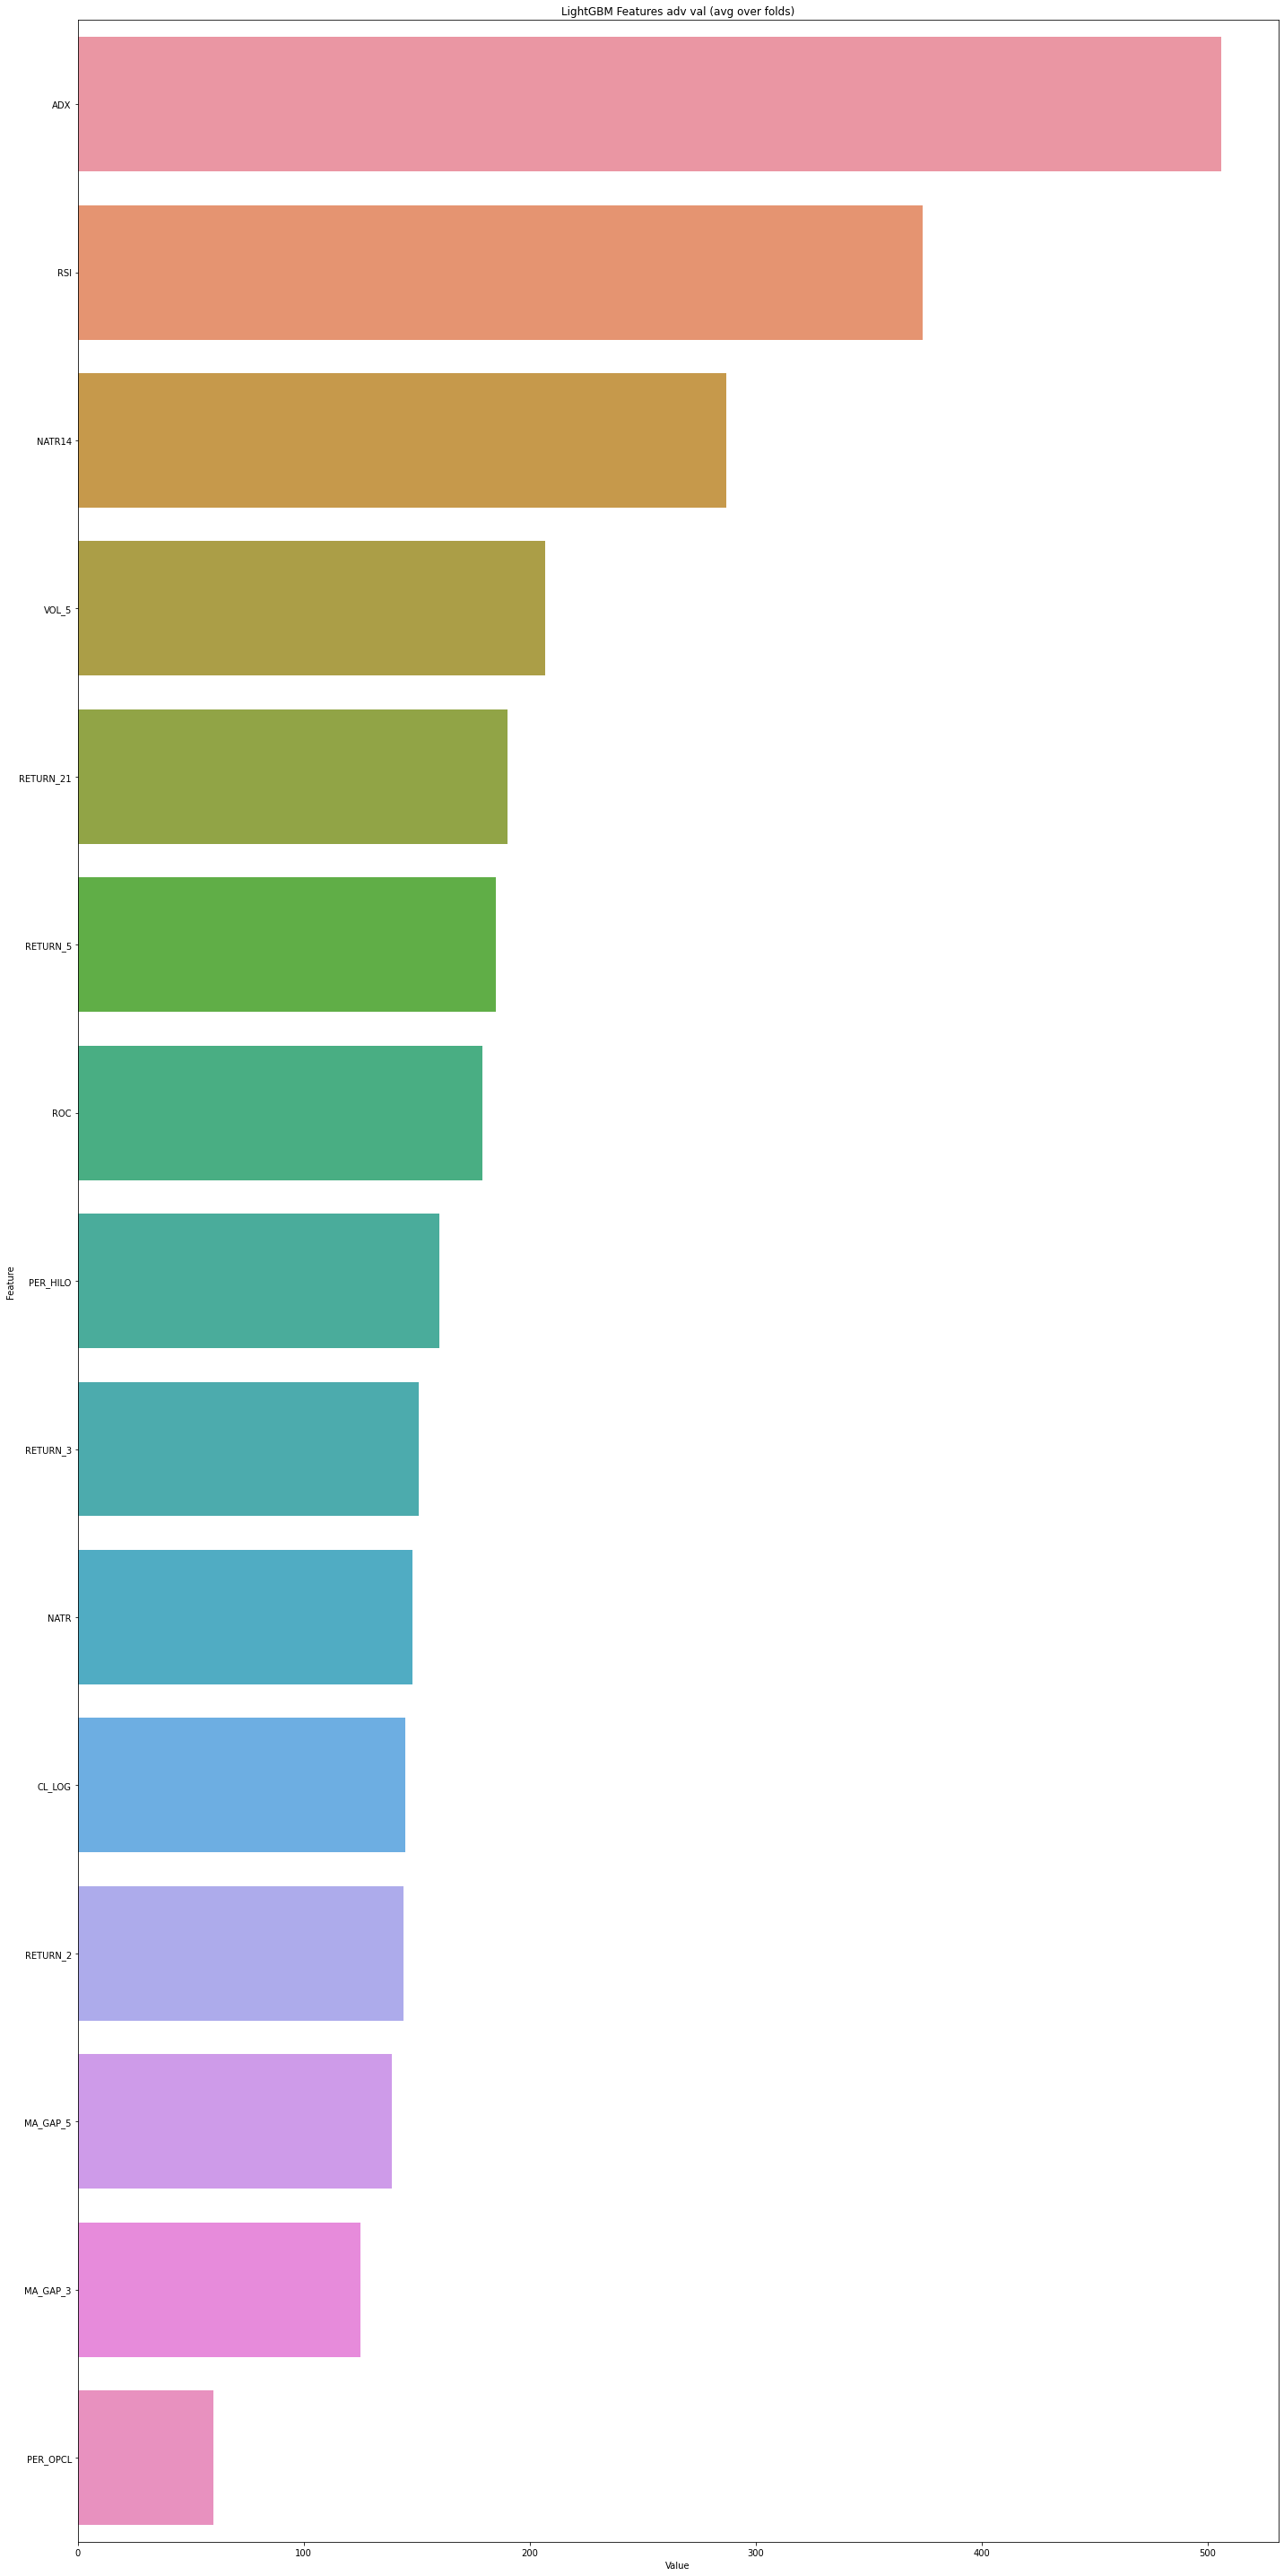

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.12646036 0.12719519]
score mean, std 0.12682777431486897 0.00036741885508001504


In [260]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_sell'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

In [261]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
df

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,...,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-07 10:15:00+00:00,2300145.0,2304572.0,2296992.0,2302299.0,401.039434,0.0,9552.032682,-2041.40,-2.314417e+06,3755.316341,...,2300311.0,1.0,2304287.0,1.0,1.0,1.0,0.000251,0.003019,-0.000863,-0.000863
2018-01-07 10:30:00+00:00,2302299.0,2305000.0,2298190.0,2299109.0,380.134787,0.0,8818.992186,-2744.85,-2.315904e+06,3037.071093,...,2297330.0,1.0,2300888.0,1.0,1.0,1.0,0.002101,0.000964,-0.000774,-0.000774
2018-01-07 10:45:00+00:00,2299109.0,2303500.0,2295150.0,2300413.0,450.116331,0.0,10056.365212,-831.85,-2.311045e+06,4612.257606,...,2298670.0,1.0,2302156.0,1.0,1.0,1.0,0.003573,-0.000339,-0.000758,-0.000758
2018-01-07 11:00:00+00:00,2300413.0,2310000.0,2297825.0,2304910.0,557.968401,0.0,5925.603724,-5248.75,-2.320336e+06,338.426862,...,2302936.0,1.0,2306884.0,1.0,1.0,1.0,0.000548,0.003169,-0.000856,-0.000856
2018-01-07 11:15:00+00:00,2304910.0,2309825.0,2297810.0,2302080.0,762.911445,0.0,6314.946760,-4953.05,-2.320039e+06,680.948380,...,2299573.0,2.0,2304197.0,1.0,0.0,1.0,0.000000,0.002007,0.000000,-0.000920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 10:00:00+00:00,4807190.0,4810305.0,4784667.0,4787506.0,58.386827,0.0,37263.941135,-304.55,-4.835359e+06,18479.695568,...,4783351.0,1.0,4764005.0,3.0,1.0,0.0,-0.004044,0.000000,-0.000868,0.000000
2022-05-06 10:15:00+00:00,4787505.0,4788359.0,4777967.0,4783588.0,38.737426,0.0,49523.322024,12446.15,-4.807794e+06,30984.736012,...,4780125.0,1.0,4764005.0,2.0,1.0,0.0,-0.003372,0.000000,-0.000724,0.000000
2022-05-06 10:30:00+00:00,4783535.0,4785876.0,4750021.0,4759306.0,93.492735,0.0,63800.286735,24810.85,-4.782127e+06,44305.568368,...,4754607.0,1.0,4764005.0,1.0,1.0,1.0,-0.002293,0.006990,-0.000987,-0.000987


毎時刻、この執行方法でトレードした場合の累積リターン


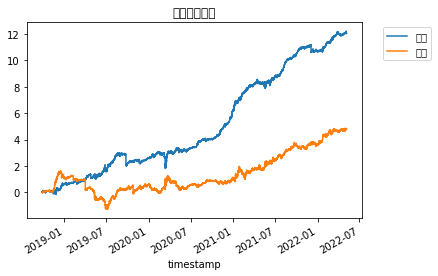

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


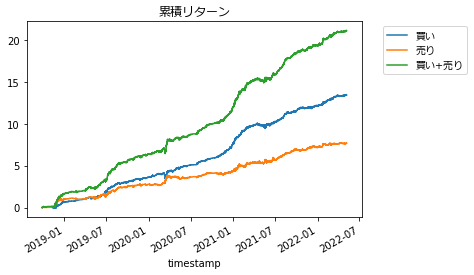

43613
40502


In [262]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
# df = df[df['y_buy']!=0]
# print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df[df['y_buy']!=0]['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

df.to_pickle('df_bf_fx_fit.pkl')

151291
毎時刻、この執行方法でトレードした場合の累積リターン


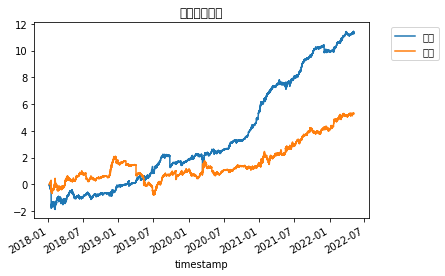

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


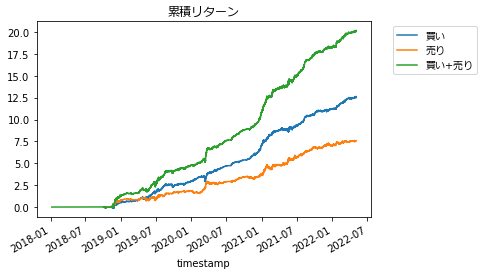

44843
40510


,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,...,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-07 10:15:00+00:00,2300145.0,2304572.0,2296992.0,2302299.0,401.039434,0.0,9552.032682,-2041.40,-2.314417e+06,3755.316341,...,2304287.0,1.0,1.0,1.0,0.000251,0.003019,-0.000863,-0.000863,0.000000,0.000000
2018-01-07 10:30:00+00:00,2302299.0,2305000.0,2298190.0,2299109.0,380.134787,0.0,8818.992186,-2744.85,-2.315904e+06,3037.071093,...,2300888.0,1.0,1.0,1.0,0.002101,0.000964,-0.000774,-0.000774,0.000000,0.000000
2018-01-07 10:45:00+00:00,2299109.0,2303500.0,2295150.0,2300413.0,450.116331,0.0,10056.365212,-831.85,-2.311045e+06,4612.257606,...,2302156.0,1.0,1.0,1.0,0.003573,-0.000339,-0.000758,-0.000758,0.000000,0.000000
2018-01-07 11:00:00+00:00,2300413.0,2310000.0,2297825.0,2304910.0,557.968401,0.0,5925.603724,-5248.75,-2.320336e+06,338.426862,...,2306884.0,1.0,1.0,1.0,0.000548,0.003169,-0.000856,-0.000856,0.000000,0.000000
2018-01-07 11:15:00+00:00,2304910.0,2309825.0,2297810.0,2302080.0,762.911445,0.0,6314.946760,-4953.05,-2.320039e+06,680.948380,...,2304197.0,1.0,0.0,1.0,0.000000,0.002007,0.000000,-0.000920,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 10:00:00+00:00,4807190.0,4810305.0,4784667.0,4787506.0,58.386827,0.0,37263.941135,-304.55,-4.835359e+06,18479.695568,...,4764005.0,3.0,1.0,0.0,-0.004044,0.000000,-0.000868,0.000000,0.000215,0.000000
2022-05-06 10:15:00+00:00,4787505.0,4788359.0,4777967.0,4783588.0,38.737426,0.0,49523.322024,12446.15,-4.807794e+06,30984.736012,...,4764005.0,2.0,1.0,0.0,-0.003372,0.000000,-0.000724,0.000000,0.000146,0.000000
2022-05-06 10:30:00+00:00,4783535.0,4785876.0,4750021.0,4759306.0,93.492735,0.0,63800.286735,24810.85,-4.782127e+06,44305.568368,...,4764005.0,1.0,1.0,1.0,-0.002293,0.006990,-0.000987,-0.000987,0.000289,0.000185


In [263]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
df_buy = df[df['y_buy']!=0]
df_sell = df[df['y_sell']!=0]
print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
# model.fit(df[features], df['y_buy'])
# joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
# model.fit(df[features], df['y_sell'])
# joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies_buy = list(TimeSeriesSplit().split(df_buy))
cv_indicies_sell = list(TimeSeriesSplit().split(df_sell))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df_buy['y_pred_buy'] = my_cross_val_predict(model, df_buy[features].values, df_buy['y_buy'].values, cv=cv_indicies_buy)
df_sell['y_pred_sell'] = my_cross_val_predict(model, df_sell[features].values, df_sell['y_sell'].values, cv=cv_indicies_sell)

df = pd.merge(df, df_buy['y_pred_buy'], left_index=True, right_index=True, how='left')
df = pd.merge(df, df_sell['y_pred_sell'], left_index=True, right_index=True, how='left')
df['y_pred_buy'] = df['y_pred_buy'].fillna(0)
df['y_pred_sell'] = df['y_pred_sell'].fillna(0)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df_buy['y_buy'].cumsum().plot(label='買い')
df_sell['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

# df.to_pickle('df_bf_fx_fit.pkl')
df

## バックテストと検定

0.46224285311289925


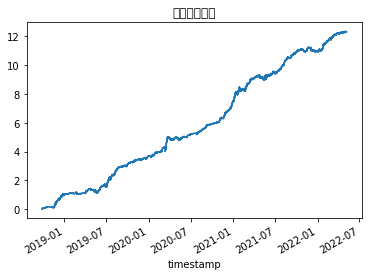

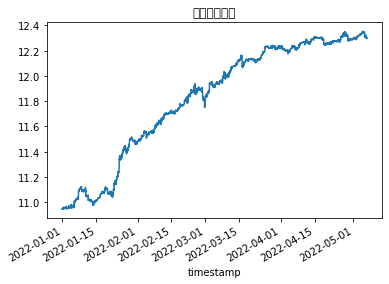

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


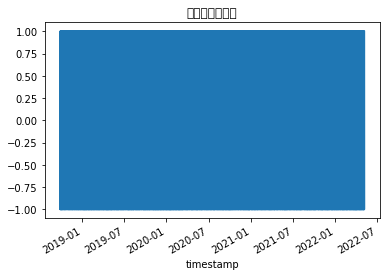

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


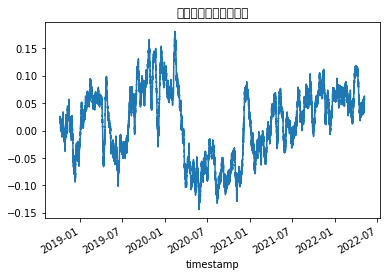

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


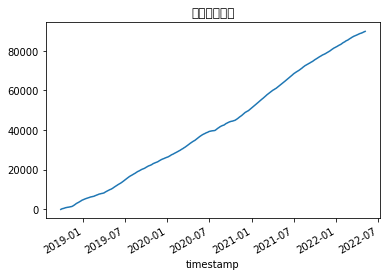

t検定
t値 9.90719134933459
p値 3.950037061424986e-23
p平均法 n = 5
p平均 0.00015531725293889905
エラー率 2.3537876454763583e-18


In [264]:
#@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None,
              date_time=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    old_ret = 0.0
    print_date = '2022-03-01 00:00:00'
    print_ret = 0.0

    for i in range(n):
        prev_pos = pos

        # exit
        if buy_cost[i]:
        #if sell_entry[i] < 0 and buy_cost[i]:
        #if buy_entry[i] < 0 and buy_cost[i]:
            #vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
        #if buy_entry[i] < 0 and sell_cost[i]:
        #if sell_entry[i] < 0 and sell_cost[i]:
            #vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] > 0 and buy_cost[i]:
        #if buy_entry[i] > 0 and buy_cost[i] and buy_entry[i] >= sell_entry[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] > 0 and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos

        if date_time[i] > print_date:
            print_ret += (ret - old_ret)
        old_ret = ret
            

    print(print_ret)
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df_index = df
df_index['datetime'] = pd.to_datetime(df_index.index)
df_index['datetime'] = df_index['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    # buy_entry=df['y_pred_buy'].values > 0,
    # sell_entry=df['y_pred_sell'].values > 0,
    buy_entry=df['y_pred_buy'].values,
    sell_entry=df['y_pred_sell'].values,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
    date_time=df_index['datetime'].values,
)


df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

df[df.index.year == 2022]['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [265]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [266]:
# #OHLCV取得
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
# unixtime = datetime.datetime.now().timestamp() * 1000
# target_coin = "FX_BTC_JPY"
# ohlc_list=[]

# #1000本以上の1分足を取得
# while len(ohlc_list) < 1000:
#     response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
#     ohlc_list.extend(response)
#     current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
#     next_before = current_after - timedelta(minutes=1)
#     unixtime = int(next_before.timestamp() * 1000)
#     time.sleep(1)

# df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
# df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
# df_1m.set_index("timestamp",inplace=True)
# df_1m.sort_index(inplace=True)

# #15分足に変換
# df = pd.DataFrame()
# rule = "15T"
# df["op"] = df_1m["op"].resample(rule).first()
# df["hi"] = df_1m["hi"].resample(rule).max()
# df["lo"] = df_1m["lo"].resample(rule).min()
# df["cl"] = df_1m["cl"].resample(rule).last()
# df["volume"] = df_1m["volume"].resample(rule).sum()

# #特徴量の計算
# df_features = calc_features(df)

# #モデルの読み込み
# model_y_buy = joblib.load('./model/model_y_buy_bffx.xz')
# model_y_sell = joblib.load('./model/model_y_sell_bffx.xz')

# #推論
# df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
# df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

# #ポジションの判定

# #買いポジションの判定
# def calc_position_buy(x):
#     buy = x["predict_y_buy"]
#     if buy > 0:
#         return "buy"
#     else:
#         return "none"
    
# #売りポジションの判定
# def calc_position_sell(x):
#     buy = x["predict_y_sell"]
#     if buy > 0:
#         return "sell"
#     else:
#         return "none"

# df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
# df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

# display(df_features)

# position_buy = df_features["position_buy"].iloc[-1]
# position_sell = df_features["position_sell"].iloc[-1]

# if position_buy == "buy" and position_sell == "none":
#     print("Buy Bitcoin")
# elif position_sell == "sell" and position_buy == "none":
#     print("Sell Bitcoin")
# else:
#     print("N/A")


In [267]:
#初回だけ実行
#!pip install optuna

import optuna
optuna.logging.disable_default_handler()
import warnings
warnings.filterwarnings('ignore')


def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 0.01

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['cl'] - limit_price_dist
    df['sell_price'] = df['cl'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['lo'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['hi'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['cl'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['cl'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_bf_fx_features.pkl')
df_features = df_features[df_features.index > pd.to_datetime('2022-01-01 00:00:00Z')]
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    print("atr:{} score{}".format(atr,score))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

atr:1.987709768155656 score-0.3037366463991332
atr:1.9380897634421148 score-0.4247784512955549
atr:0.016165115852845302 score-1.6537805423977519
atr:0.37462225793578696 score-0.19012823701040882
atr:0.051200936010556086 score0.22132392160048375
atr:0.9116143285552925 score-1.304562533482795
atr:1.3889742583066513 score-0.7501030374501165
atr:1.83571540952293 score-0.115182634860713
atr:1.42760303728833 score-0.7277781692420904
atr:1.3549870971042606 score-0.6220233885490825
atr:0.6476642508541512 score-0.014369560820991056
atr:0.5693192375533609 score-0.46809912043832425
atr:0.10001805223912685 score2.196707334152396
atr:0.007800123158854269 score-2.340914430964065
atr:0.26146057918412846 score1.4774116935662989
atr:0.338121614951544 score0.44988118461260973
atr:0.323021473961288 score0.21422497625150438
atr:0.8961319653472953 score-1.4240952260355817
atr:0.5932674786366484 score-0.6255020547405327
atr:1.108807314739218 score-2.084198387292519
atr:0.2502897748038699 score1.596236089268